## Competition

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

In [14]:
def power_competition(n,B=250,m=150):
        
   np.random.seed(42)

   esperances = []
   variances = []
   test_statistics = []
   test_alternative = []
   power = []

   beta1 = 2
   beta2_values = np.linspace(0, 0.16, 9)

   epsilon = np.random.normal(0, 1, n)
   x = np.random.uniform(0, 5, n)

   bootstrap_indices = np.random.choice(n, size=(B, n), replace=True) # bootstrapping

   for beta2 in beta2_values:
       
       epsilon_test = np.random.normal(0, 1, m)
       x_test = np.random.uniform(0, 5, m)
       y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test
       
       db = []
       
       for bootstrap_index in bootstrap_indices:
       
          x_train = x[bootstrap_index]
          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon[bootstrap_index]

          x_train_reshape = x_train.reshape(-1, 1) # fit pour le modèle 

          model_a1 = LinearRegression().fit(x_train_reshape, y_train) # Modèle linéaire
          y_pred_a1 = model_a1.predict(x_test.reshape(-1,1))
          p1b = mean_squared_error(y_test, y_pred_a1)

          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_a2 = LinearRegression().fit(x_train_quad, y_train)          
          y_pred_a2 = model_a2.predict(x_test_quad)
          p2b = mean_squared_error(y_test, y_pred_a2)

          db.append(p1b - p2b)  # Différence des moyennes de performance sur chaque bootstrap

       # Fin du boostrapping

       d_barre = sum(db)/B # Converge p.s vers l'espérance mu

       var = np.var(db, ddof=1)
       test_stat = (B**0.5)*d_barre/np.sqrt(var) # Statistique pour l'hypothèse nulle

       delta = np.mean(db)
       student = stats.t.ppf(0.95, df=B-1)
       mu = (B ** 0.5)*delta/np.sqrt(var)
       test_alt = student - mu
       puissance = 1 - stats.norm.cdf(student - mu, 0, 1)
       
       esperances.append(d_barre)
       variances.append(var)
       test_statistics.append(test_stat)
       test_alternative.append(test_alt)
       power.append(puissance)

   return esperances, variances, test_statistics, test_alternative, power


In [21]:
delta = (stats.t.ppf(0.95, 249) - stats.norm.ppf(0.2))*(8.079221985442372e-05)/(250**0.5)
delta

1.2736648292381007e-05

In [15]:
esperances, variances, test_statistics, test_alternative, power = power_competition(n=150, B=250)

print(f"Espérances: {esperances}")
print(f"Variances: {variances}")
print(f"Statistiques de test: {test_statistics}")
print(f"Test alternative: {test_alternative}")
print(f"Puissance: {power}")


Espérances: [-0.004573030336320981, 0.0014288798477824249, 0.007695102312823117, 0.027493368457805003, -0.011466434507665471, 0.022812241465905082, 0.012403100177992754, 0.05984567721906577, 0.1096730575294107]
Variances: [5.8996688546400135e-05, 8.801547539748097e-05, 8.079221985442372e-05, 0.00018288010050400053, 0.00028730381142628715, 0.0001614461906729863, 0.0002230245701576181, 0.00018159199517493328, 0.00016649390696626374]
Statistiques de test: [-9.413698158078084, 2.408164755375648, 13.536289447481643, 32.14509627879174, -10.696155436286746, 28.38729840824805, 13.131789131632182, 70.21896761832544, 134.39118494050751]
Test alternative: [11.064694309755346, -0.7571686036983869, -11.88529329580438, -30.49410012711445, 12.347151587964007, -26.7363022565708, -11.48079297995492, -68.56797146664815, -132.7401887888303]
Puissance: [0.0, 0.7755255713364169, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]


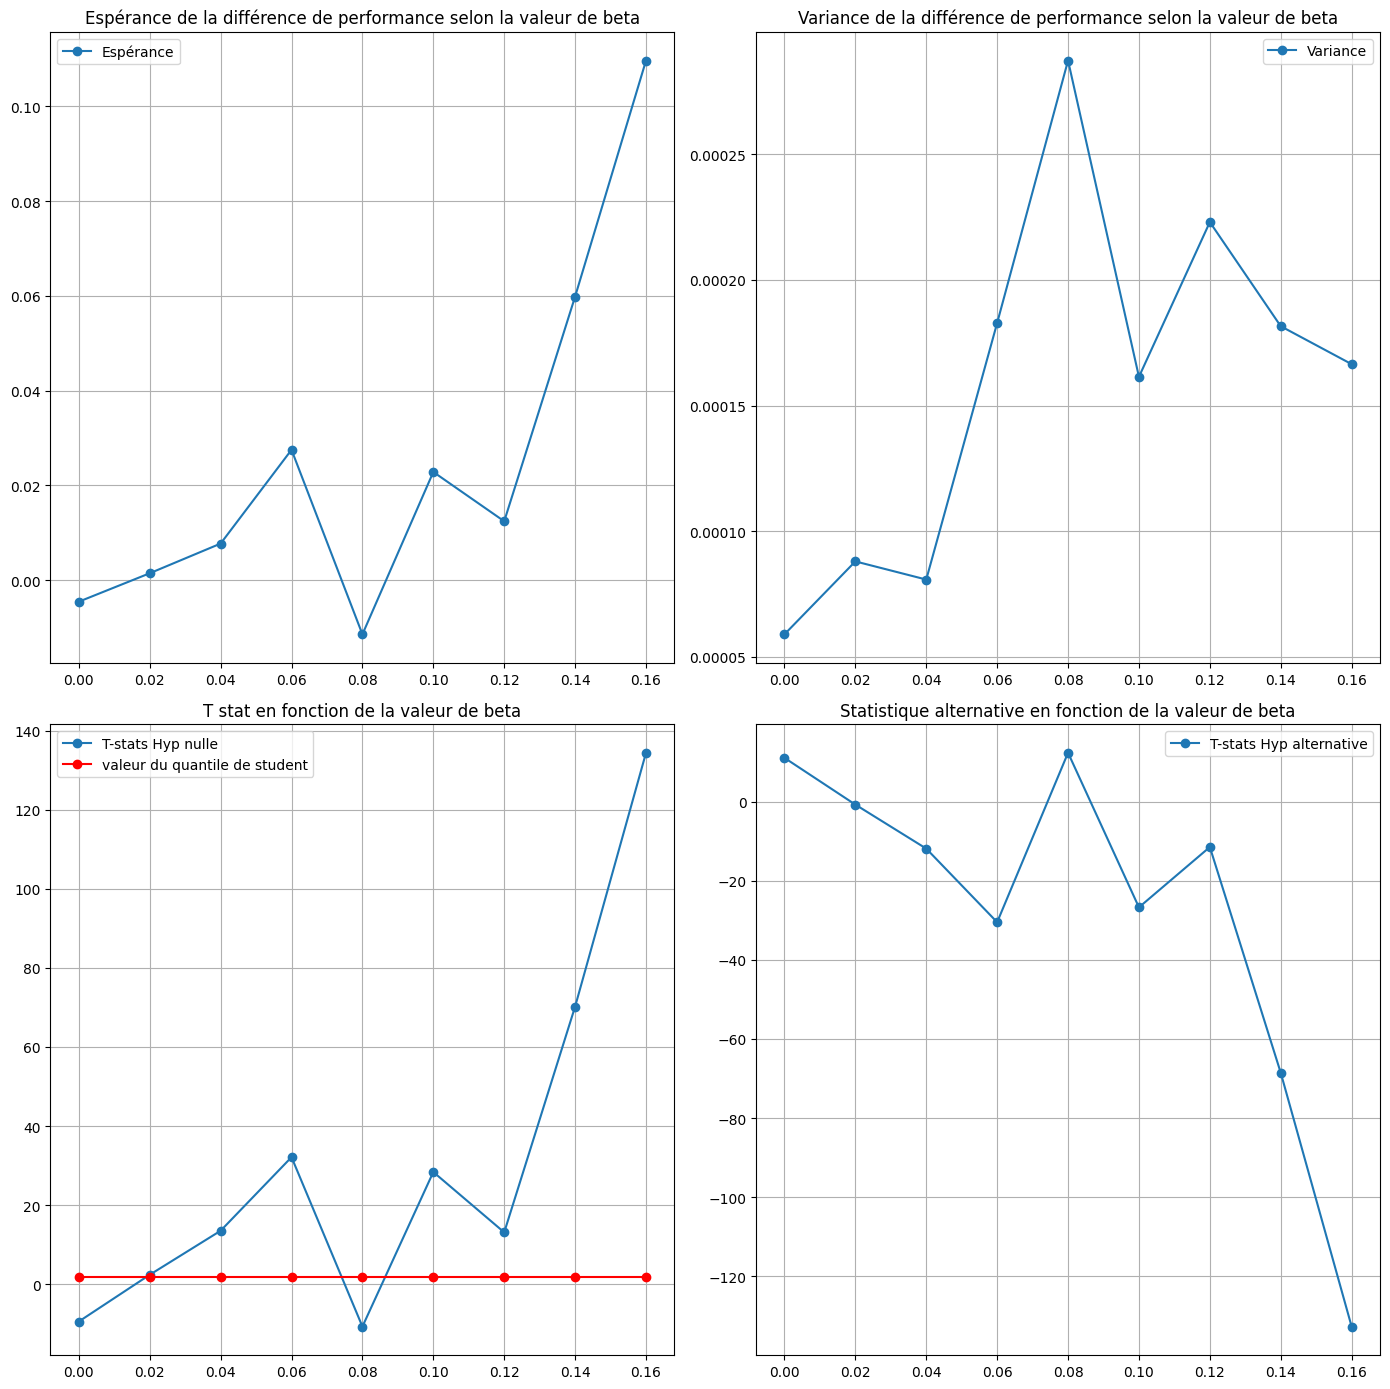

In [16]:
beta2_values = np.linspace(0, 0.16, 9)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

# Premier sous-graphe : Espérance
axes[0, 0].plot(beta2_values, esperances, label='Espérance', marker='o')
axes[0, 0].set_title('Espérance de la différence de performance selon la valeur de beta')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Deuxième sous-graphe : Variance
axes[0, 1].plot(beta2_values, variances, label='Variance', marker='o')
axes[0, 1].set_title('Variance de la différence de performance selon la valeur de beta')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Troisième sous-graphe : T-stat Hyp nulle
axes[1, 0].plot(beta2_values, test_statistics, label='T-stats Hyp nulle', marker='o')
axes[1, 0].plot(beta2_values, [stats.t.ppf(0.95, df=9)]*len(beta2_values), label='valeur du quantile de student', color='r', marker='o')
axes[1, 0].set_title('T stat en fonction de la valeur de beta')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Quatrième sous-graphe : T-stat Hyp alternative
axes[1, 1].plot(beta2_values, test_alternative, label='T-stats Hyp alternative', marker='o')
axes[1, 1].set_title('Statistique alternative en fonction de la valeur de beta')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

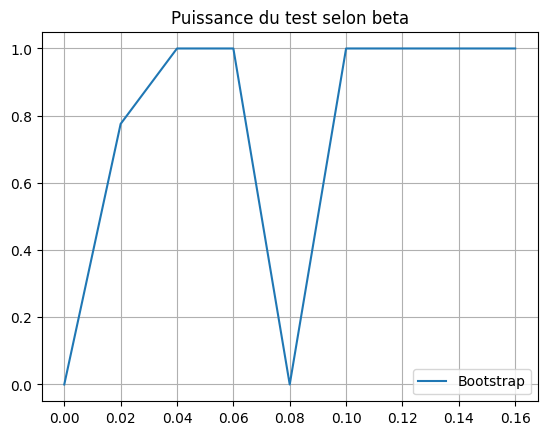

In [17]:
plt.figure()
plt.title("Puissance du test selon beta")
plt.plot(beta2_values, power, label = "Bootstrap")
plt.grid()
plt.legend()
plt.show()

In [18]:
df_comp = pd.DataFrame(power)
df_comp

,0
0,0.000000
1,0.775526
2,1.000000
3,1.000000
4,0.000000
5,1.000000
6,1.000000
7,1.000000
8,1.000000
